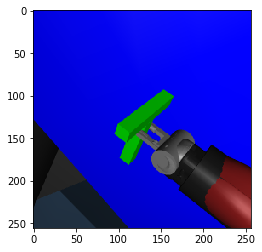

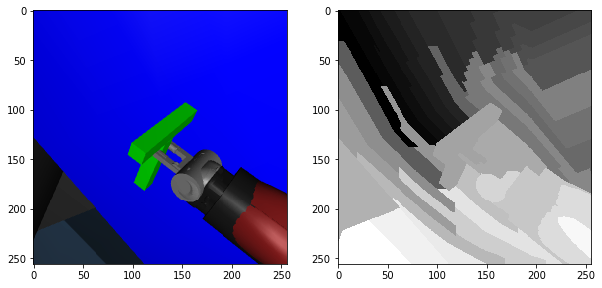

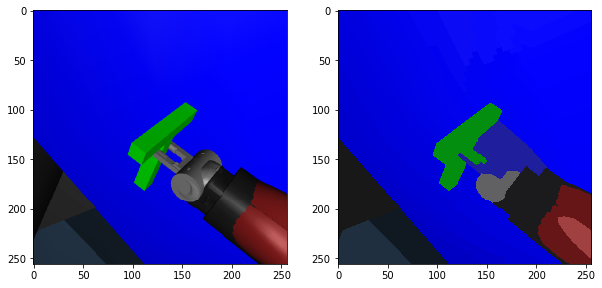

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

import skdemo
#plt.rcParams['image.cmap'] = 'spectral'
from skimage import io, segmentation as seg, color

image = np.load("/home/rllab/robosuite-gqcnn/robosuite/robosuite/scripts/test_3.npz")["arr_0"]
depth = np.load("/home/rllab/robosuite-gqcnn/robosuite/robosuite/scripts/test_3.npz")["arr_1"]
plt.imshow(image)
plt.show()

labels = seg.slic(image, n_segments=50, compactness=0.1)
skdemo.imshow_all(image, labels.astype(float) / labels.max())

def mean_color(image, labels):
    out = np.zeros_like(image)
    for label in np.unique(labels):
        indices = np.nonzero(labels == label)
        out[indices] = np.mean(image[indices], axis=0)
    return out

skdemo.imshow_all(image, mean_color(image, labels))

/home/rllab/.conda/envs/robosuite/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


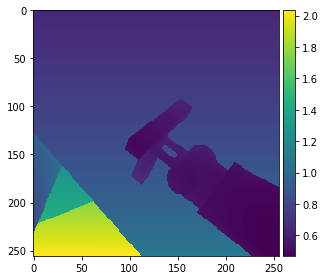

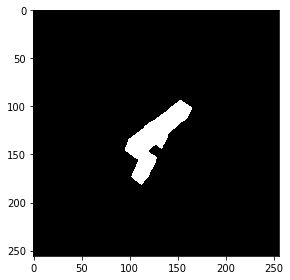

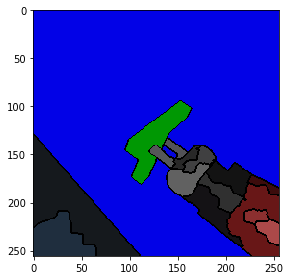

In [2]:
from skimage.future import graph

def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}

def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])
    
labels = seg.slic(image, compactness=30, n_segments=400)
g = graph.rag_mean_color(image, labels)

labels2 = graph.merge_hierarchical(labels, g, thresh=35, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)
out = color.label2rgb(labels2, image, kind='avg')
mask = np.zeros((256, 256))
for i in range(256):
    for j in range(256):
        if np.argmax(out[i, j, :]) == 1 and np.max(out[i, j, :]) - np.min(out[i, j, :]) > 20:
            #if np.abs(out[i, j, 0] - out[i, j, 1]) < 10 and np.abs(out[i, j, 0] - out[i, j, 2]) < 10 and np.abs(out[i, j, 1] - out[i, j, 2]) < 10:
            #    continue
            mask[i, j] = 1
io.imshow(depth)
io.show()
io.imshow(mask)
io.show()
out = seg.mark_boundaries(out, labels2, (0, 0, 0))
io.imshow(out)
io.show()